In [29]:
%matplotlib tk
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import scipy.linalg as la

from serial_solver import *

from scipy.integrate import quadrature as quad

import scipy.sparse as sps
from scipy.sparse.linalg import bicgstab, bicg, spilu, LinearOperator, gmres

from scipy.stats import linregress as linreg

import pickle

In [30]:
def to_polar(node):
    x, y = node
    r = np.sqrt(x**2 + y**2)
    if x==0:
        if y==0:
            theta = 0
        elif y>0:
            theta = np.pi/2
        else:
            theta = -np.pi/2
    else:
        theta = np.arctan(y/x)
        if x<0:
            theta += np.pi
    return r, theta

def to_cart(theta):
    return np.cos(theta), np.sin(theta)

def boudnary(node):
    return node[0]

def pol_bndry(theta):
    return boundary(to_cart(theta))


In [31]:
def u_true(node, A, B):
    r, th = to_polar(node)
    ret = 0
    for i, (a,b) in enumerate(zip(A,B)):
        ret += a * r**i * np.cos(i*th) 
        ret += b * r**i * np.sin(i*th)
    return ret

def plot_u_true(A, B):
    xi = np.linspace(-1,1,200)
    yi = np.linspace(-1,1,200)
    X, Y = np.meshgrid(xi, yi)
    zi = np.array([ [u_true((x,y), A, B) if dist((x,y),(0,0))<=1 else 0 for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X,Y) ])
    
    plt.pcolormesh(X,Y,zi, cmap=cm.coolwarm)
    
    th = np.linspace(0, 2*np.pi)
    plt.plot(np.cos(th), np.sin(th), 'k-')
    
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.show()


def bnd0_f(node):
    r, th = to_polar
    return np.cos(th)
def bnd0():
    A = np.zeros(10)
    B = np.zeros(10)
    A[1] = 1
    return bnd0_f, A, B

def bnd1_f(node):
    r, th = to_polar(node)
    return np.cos(2*th) - 3*np.sin(3*th)
def bnd1():
    A = np.zeros(10)
    B = np.zeros(10)
    A[2] = 1
    B[3] = -3
    return bnd1_f, A, B

def bnd2_f(node):
    r, th = to_polar(node)
    return np.cos(2*th) + 1/3*np.sin(3*th) + 1/20*np.cos(5*th)
def bnd2():
    A = np.zeros(10)
    B = np.zeros(10)
    A[2] = 1
    B[3] = 1/3
    A[5] = 1/20
    return bnd2_f, A, B

def bnd3_f(node):
    r, th = to_polar(node)
    return .2*np.cos(5*th) + .1*np.sin(13*th) - .05*np.cos(17*th)
def bnd3():
    A = np.zeros(20)
    B = np.zeros(20)
    A[5] = .2
    B[13] = .1
    A[17] = -.05
    return bnd3_f, A, B

def bnd4_f(node):
    r, th = to_polar(node)
    i = np.arange(10)+1.0
    A = (i)**-2 * (-1.0)**i
    A[0] = 0
    B = i**-2
    return np.sum(A*np.cos(i*th) + B*np.sin(i*th))
def bnd4():
    i = np.arange(10)+1.0
    A = (i)**-2 * (-1.0)**i
    A[0] = 0
    B = i**-2
    return bnd4_f, A, B



# Error Plots

In [37]:
bnd_true, A, B = bnd2()

#ls     = [10, 10, 12, 20, 30]
pdims  = [1, 3, 6, 10, 15, 21]

#pdims = range(1,11)

ls = [max(2*pdim,10) for pdim in pdims]

ns = [30*2**i for i in range(12)]
max_errors = []

#l = 25
#pdim = 10

for pdim, l in zip(pdims,ls):
    ers = []
    for n in ns:
        nb = int(n**.5) * 4
        inner, outer = gen_points(n,nb, dist='vogel')
        u, C, b_vec = rbf_fd(inner, outer, l, pdim, boundary=bnd_true)
        rbf_u = u[:n]
        
        #transpose testing
        if True:
            CT = C[:,:n]
            rhs = C[:,n:]@b_vec
            if True:
                rhs = CT.T@rhs
                CT = CT.T@CT
            rbf_u = spsolve(CT, rhs)

        u_exact = np.array([u_true(node, A, B) for node in inner])
        ers += [np.max(np.abs(rbf_u - u_exact))]
        print(n, nb, l, pdim, ers[-1])
    max_errors += [ers]

30 20 10 1 0.09738678186259714
60 28 10 1 0.06698542330606949
120 40 10 1 0.06386613398405416
240 60 10 1 0.05359576747865896
480 84 10 1 0.07675651219025381
960 120 10 1 0.09863765413759118
1920 172 10 1 0.09463619516058219
3840 244 10 1 0.20631536462877612
7680 348 10 1 0.36686366143944366
15360 492 10 1 0.5272755978738357
30720 700 10 1 0.3423063457758181
61440 988 10 1 0.615836483086009
30 20 10 3 0.08694433715610082
60 28 10 3 0.046265196748591225
120 40 10 3 0.02166901928742576
240 60 10 3 0.019259380307214927
480 84 10 3 0.018495425736943127
960 120 10 3 0.027025835562992248
1920 172 10 3 0.01753390028740226
3840 244 10 3 0.015915801142424316
7680 348 10 3 0.026978971616683174
15360 492 10 3 0.02861561328798501
30720 700 10 3 0.016282401040126127
61440 988 10 3 0.021291399072548126
30 20 12 6 0.021008343947913545
60 28 12 6 0.011932958210532835
120 40 12 6 0.0036033704787042167
240 60 12 6 0.001658946398935962
480 84 12 6 0.0009391058365834093
960 120 12 6 0.0006124780879897089


In [39]:
f = open('convergence_transpose.pickle', 'wb')
pickle.dump(max_errors, f)
f.close()

In [ ]:
f = open('convergence_transpose.pickle', 'wb')
pickle.dump(max_errors, f)
f.close()

In [53]:
f = open('convergence_transpose.pickle', 'rb')
max_errors = pickle.load(f)
f.close()

In [50]:
f = open('convergence_GMRES.pickle', 'rb')
max_errors = pickle.load(f)
f.close()

In [54]:
#deg_errs = [max_errors[i-1] for i in (1, 3, 6, 10)]
deg_errs = max_errors
orders = []
powers = range(len(deg_errs))

#plt.figure(figsize=(8,8))
matplotlib.rcParams.update({'font.size': 16})

fig1, ax1 = plt.subplots(figsize=(8,8))

for i, ers in enumerate(deg_errs):
    log_ers = np.log(ers)
    log_n = np.log(ns)
    m, b, *ignore = linreg(log_n, log_ers)
    print(powers[i], m)
    leg = 'deg %d ~ O(N^%f)' % (powers[i], m)
    ax1.loglog(ns, ers, label=leg)
ax1.set_title('Convergence Rates using CG on D^TD')
ax1.set_xlabel('N')
ax1.set_ylabel('Max Error')
ax1.legend(loc=6, borderaxespad=0.1)
ax1.set_xscale('log')
ax1.set_xticks(ns[1::2])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

0 0.31420137542123283
1 -0.11161652683092159
2 -0.8078166379623553
3 -1.000164964500124
4 -1.6603422214418533
5 2.0449543588097


In [6]:
bnd_true, A, B = bnd2()

n = 10**2
nb = int(2*n**.5)
l = 20
pdim = 10

inner, outer = gen_points(n,nb, dist='halton')

#u, C, b_vec = rbf_fd(inner, outer, l, pdim, boundary=bnd_true)
C, b_vec = gen_system(inner, outer, l, pdim, boundary=bnd_true)


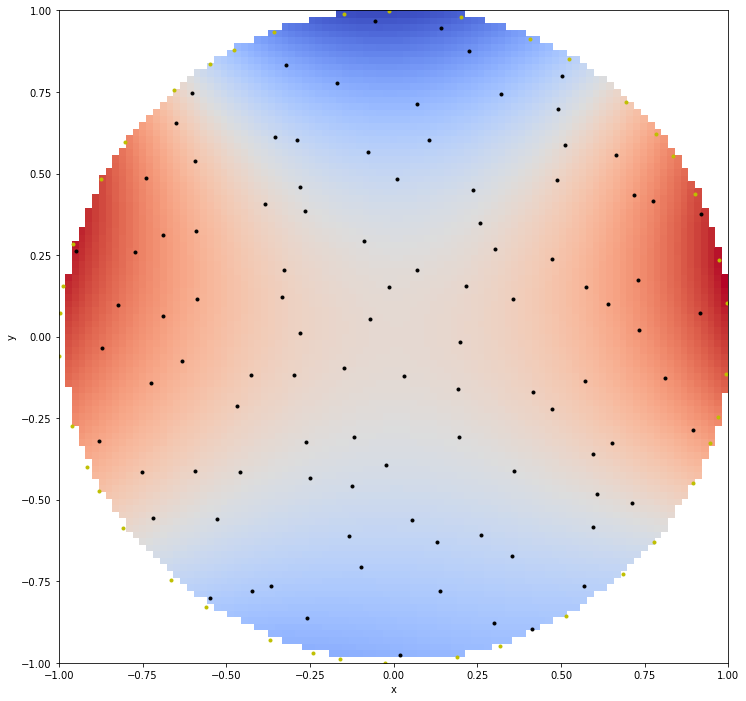

Max error: 0.0016276
Max interior error: 0.0016276


In [7]:
bnd_true, A, B = bnd2()

n = 10**2
nb = int(n**.5) * 4
l = 25
pdim = 10

inner, outer = gen_points(n,nb, dist='halton')

u, C, b_vec = rbf_fd(inner, outer, l, pdim, boundary=bnd_true)

plt.figure(figsize=(12,12))
plot_disk(inner, outer, u, points=True, boundary=True)

rbf_u = u[:n]

u_exact = np.array([u_true(node, A, B) for node in inner])

errors = np.abs(rbf_u - u_exact)

print('Max error: %g' % np.max(errors) )

max_inner = 0
for e, node in zip(errors, inner):
    if e>max_inner and dist(node, (0,0))<.8 :
        max_inner = e
print('Max interior error: %g' % max_inner)
    

In [6]:
inner, outer = read_points('point_sets/test.dat')
C, rhs = gen_system(inner, outer, 3, 1)
print(C.todense()[5])

[[  0.           0.           6.57261751   0.           0.
  -12.50846232   0.           0.           5.93584481   0.
    0.           0.           0.           0.           0.        ]]
